# **Install and Import Modules**

In [ ]:
!pip install transformers[sentencepiece] evaluate datasets sacrebleu rouge_score py7zr -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from transformers import pipeline, set_seed
from datasets import load_dataset
from evaluate import load
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')
warnings.filterwarnings('ignore')
set_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Load Dataset**

In [ ]:
dataset= load_dataset("cnn_dailymail", "3.0.0")

print(f'Dataset train size: {len(dataset["train"])}')
print(f'Dataset test size: {len(dataset["test"])}')
print(f'Dataset validation size: {len(dataset["validation"])}')
print(f'Dataset Feature: {dataset["train"].column_names}')

Dataset train size: 287113
Dataset test size: 11490
Dataset validation size: 13368
Dataset Feature: ['article', 'highlights', 'id']


# **Take Sample Text**

In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
print(sample_text)
summaries = {}

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow dir

# **Summarization Baseline**

In [ ]:
def baseline_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = baseline_summary(sample_text)

# **GPT-2**

In [ ]:
pipe_gpt = pipeline('text-generation', model='gpt2-medium')
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out_gpt = pipe_gpt(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out_gpt[0]['generated_text'][len(gpt2_query):]))

# **T5**

In [ ]:
pipe_t5 = pipeline('summarization', model='t5-small')
pipe_out_t5 = pipe_t5(sample_text)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out_t5[0]['summary_text']))

# **BART**

In [ ]:
pipe_bart = pipeline('summarization', model='facebook/bart-large-cnn')
pipe_out_bart = pipe_bart(sample_text)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
summaries['bart'] = '\n'.join(sent_tokenize(pipe_out_bart[0]['summary_text']))

# **Pegasus**

In [ ]:
pipe_pegasus = pipeline('summarization', model='google/pegasus-cnn_dailymail')
pipe_out_pegasus = pipe_pegasus(sample_text)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
summaries['pegasus'] = pipe_out_pegasus[0]['summary_text'].replace(" .<n>", ".\n")

# **Comparing Summaries**

In [ ]:
print('Ground Truth')
print(dataset['train'][1]['highlights'])

for model_name, summary in summaries.items():
  print(f'\n{model_name.upper()}')
  print(summary)

Ground Truth
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
- It seems some people that can't take a little heat get thrown in with people who can.
The mentally ill tend to be the ones sent to the eighth floor
- If police call this a jail, they're pretty hard hit- We even tried

# **SacreBLEU**

In [ ]:
bleu_metric = load('sacrebleu')
list_result = []
for model_name, summary in summaries.items():
    results = bleu_metric.compute(predictions=[summary], references=[dataset['train'][1]['highlights']])
    results['precisions'] = [np.round(p, 2) for p in results['precisions']]
    df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name.upper()])
    list_result.append(df)

df_result = pd.concat(list_result, axis=1)
df_result

,BASELINE,GPT2,T5,BART,PEGASUS
score,8.379861,1.500006,1.879075,21.296284,22.382122
counts,"[28, 9, 4, 3]","[10, 1, 0, 0]","[10, 1, 0, 0]","[25, 13, 10, 6]","[18, 12, 11, 10]"
totals,"[90, 89, 88, 87]","[72, 71, 70, 69]","[47, 46, 45, 44]","[57, 56, 55, 54]","[56, 55, 54, 53]"
precisions,"[31.11, 10.11, 4.55, 3.45]","[13.89, 1.41, 0.71, 0.36]","[21.28, 2.17, 1.11, 0.57]","[43.86, 23.21, 18.18, 11.11]","[32.14, 21.82, 20.37, 18.87]"
bp,1.0,1.0,0.808345,1.0,0.982301
sys_len,90,72,47,57,56
ref_len,57,57,57,57,57


# **ROUGE**

In [ ]:
rouge_metric = load('rouge')

In [ ]:
rouge_names = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

reference = dataset['train'][1]['highlights']

records = []

for model_name, summary in summaries.items():
    rouge_metric.add(prediction=summary, reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names) # Access the fmeasure value directly
    records.append(rouge_dict)

df_result = pd.DataFrame.from_records(records, index=summaries.keys())
df_result

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.172414,0.035088,0.120690,0.172414
t5,0.195652,0.022222,0.108696,0.173913
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


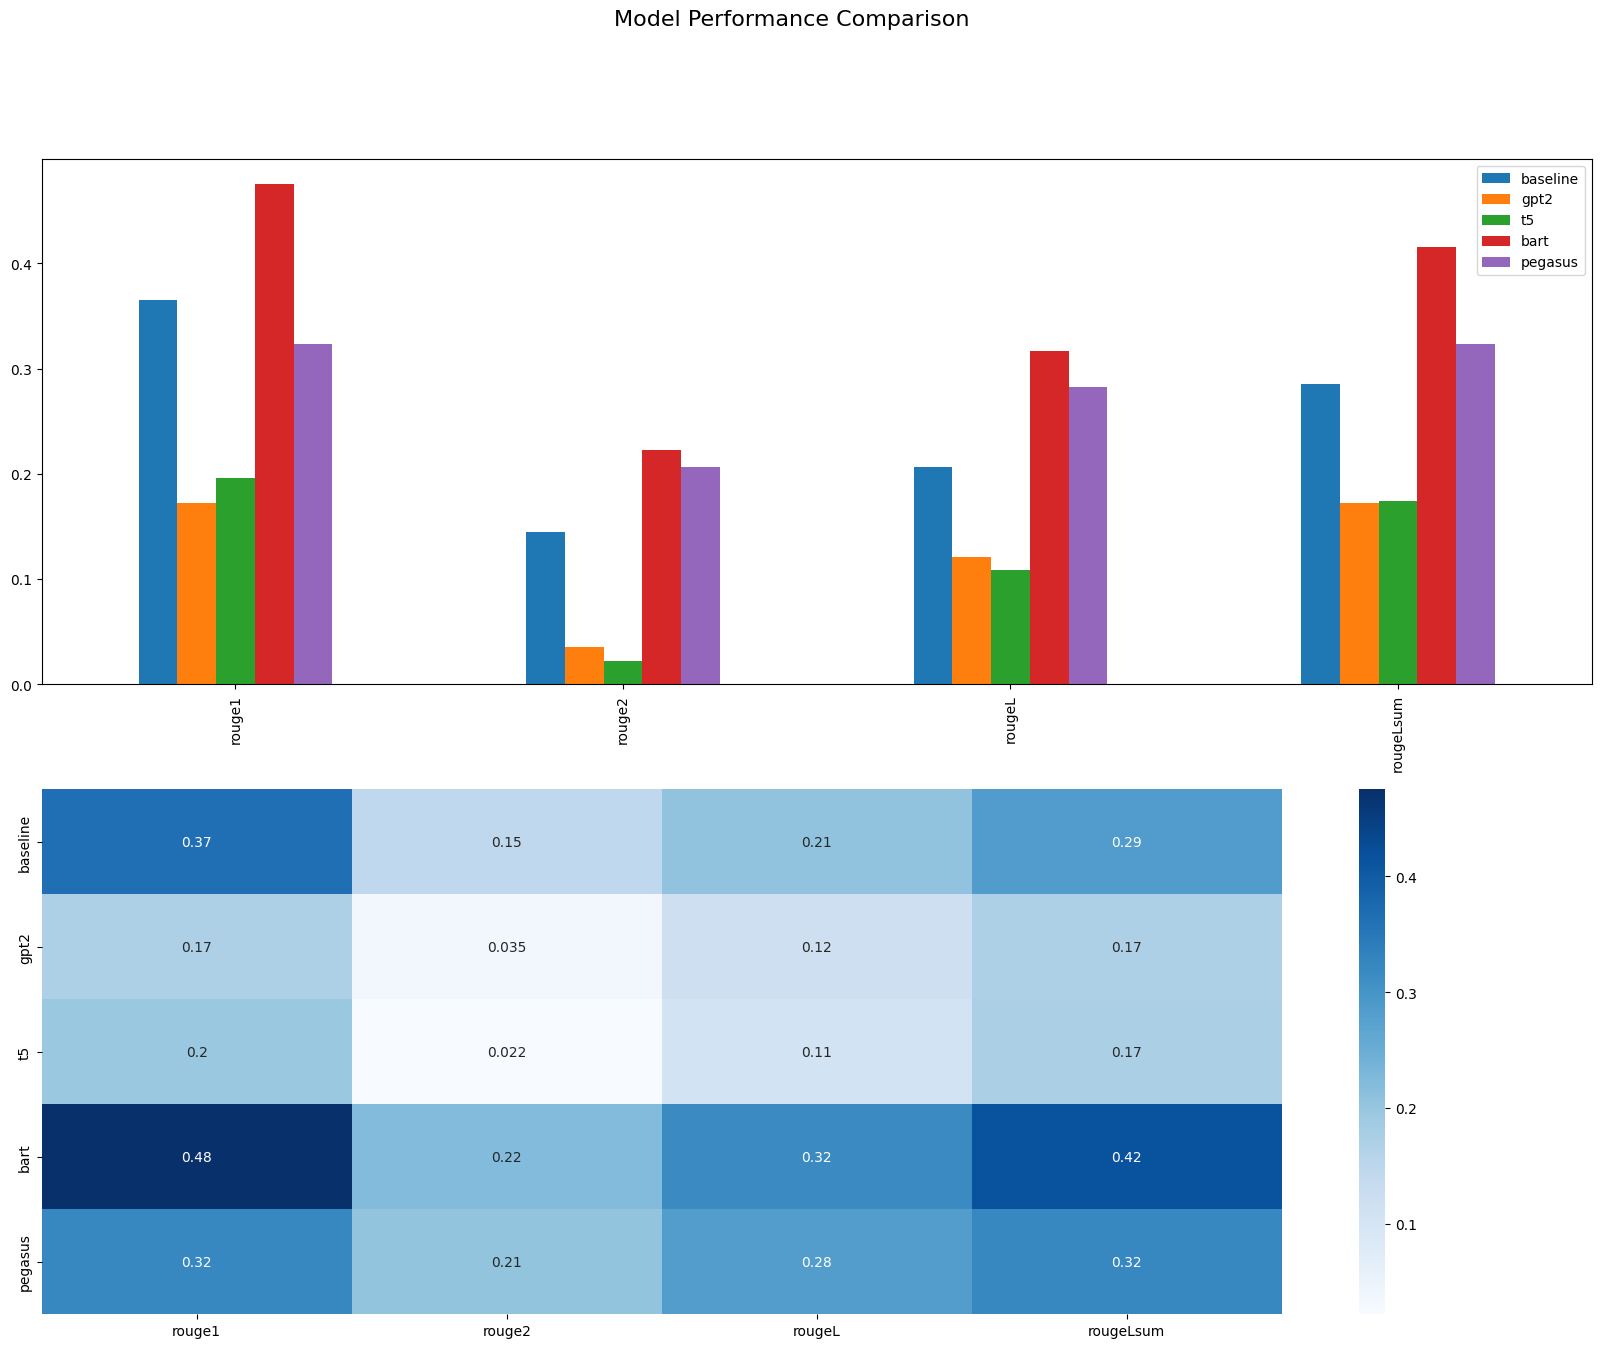

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,15))

df_result.T.plot(kind='bar', ax=ax[0])
sns.heatmap(df_result, annot=True, cmap='Blues', ax=ax[1])
fig.suptitle('Model Performance Comparison', fontsize=16)

plt.show()